In [1]:
# 训练Siamese network
# 1.构造训练数据集
# 2.搭建Siamese 网络
# 3.训练
# 4.测试

In [2]:
# 导入相关包
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
tf.__version__

'2.5.0'

In [4]:
import glob

In [5]:
# 获取测试文件夹下的所有类别
# 将后5个类别当成support set 和query

# 训练集
train_classes = glob.glob('dogImages/train/*')[:-5]
# 测试集
test_classes = glob.glob('dogImages/test/*')[:-5]

# support set 和query
query_classes = glob.glob('dogImages/train/*')[-5:]

In [6]:
len(test_classes),len(query_classes)

(128, 5)

In [7]:
query_classes

['dogImages/train\\129.Tibetan_mastiff',
 'dogImages/train\\130.Welsh_springer_spaniel',
 'dogImages/train\\131.Wirehaired_pointing_griffon',
 'dogImages/train\\132.Xoloitzcuintli',
 'dogImages/train\\133.Yorkshire_terrier']

In [8]:
# 遍历类别下的所有文件
train_files = []
# 遍历每一类
for class_item in train_classes:
    # 遍历下面所有文件
    train_file_list = glob.glob(class_item + '/*.jpg')
    train_files.append(train_file_list)
    
test_files = []
# 遍历每一类
for class_item in test_classes:
    # 遍历下面所有文件
    test_file_list = glob.glob(class_item + '/*.jpg')
    test_files.append(test_file_list)

query_files = []
# 遍历每一类
for class_item in query_classes:
    # 遍历下面所有文件
    query_file_list = glob.glob(class_item + '/*')
    query_files.append(query_file_list)


In [9]:
# query_files

In [10]:
# 构造自定义数据集
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input

In [11]:
# 无限循环提供数据集

class SiameseSequence(tf.keras.utils.Sequence ):

    def __init__(self, file_list, batch_size, batch_len):
        # 文件名列表，第一维度索引为类别
        self.file_list = file_list
        # 类别数量
        self.num_classes = len(file_list)
        # 批次
        self.batch_size = batch_size
        # 因为是模式，需要指定一下一个epoch的bach数量
        self.batch_len = batch_len

    def __len__(self):
        # 返回数据集大小
        return self.batch_len
    
    
    def __preprocess_image(self,filename):
        # 预处理图片
        
        img = image.load_img(filename, target_size=(200,200))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        return img
    
    def __getOneSample(self):
        # 获取一个样本
        
        # 随机选出所有类别里的两类
        selected_class = random.sample(range(0, self.num_classes), 2)
        
        # 从一类中挑出两张图作为A、P
        A_P_sample = random.sample( self.file_list[selected_class[0]],2)
        # 从另一类中挑出两张图作为N
        N_sample = random.sample( self.file_list[selected_class[1]],1)
        
        # 返回
        return A_P_sample[0],A_P_sample[1],N_sample[0]

    def __getitem__(self, idx):
        # 获取一批数据
        
        batch_A = []
        batch_P = []
        batch_N = []
        
        for i in range(self.batch_size):
            A,P,N = self.__getOneSample()
            
            batch_A.append(self.__preprocess_image(A))
            batch_P.append(self.__preprocess_image(P))
            batch_N.append(self.__preprocess_image(N))
            
            
        return np.array(batch_A),np.array(batch_P),np.array(batch_N)


In [12]:
# 实例化构造数据集
traingen = SiameseSequence(train_files,32,100)
test_gen = SiameseSequence(test_files,32,10)
query_gen = SiameseSequence(query_files,32,10)

In [14]:
import cv2

In [15]:

def visualize(anchor, positive, negative):
    # 显示一组图像
    fig = plt.figure(figsize=(9, 9))

    def changeImg(img):
        max_v = img.max()
        min_v = img.min()
        img =(img - min_v )/ max_v 
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
    for i in range(3):
        plt.subplot(3, 3, 3*i+1)
        plt.imshow(changeImg( anchor[i]))
        plt.title('anchor')
        plt.axis('off')    
        
        plt.subplot(3, 3, 3*i+2)
        plt.imshow(changeImg( positive[i]))        
        plt.title('positive')
        plt.axis('off')    
        
        plt.subplot(3, 3, 3*i+3)
        plt.imshow(changeImg( negative[i]))        
        plt.title('negative')
        plt.axis('off')    




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


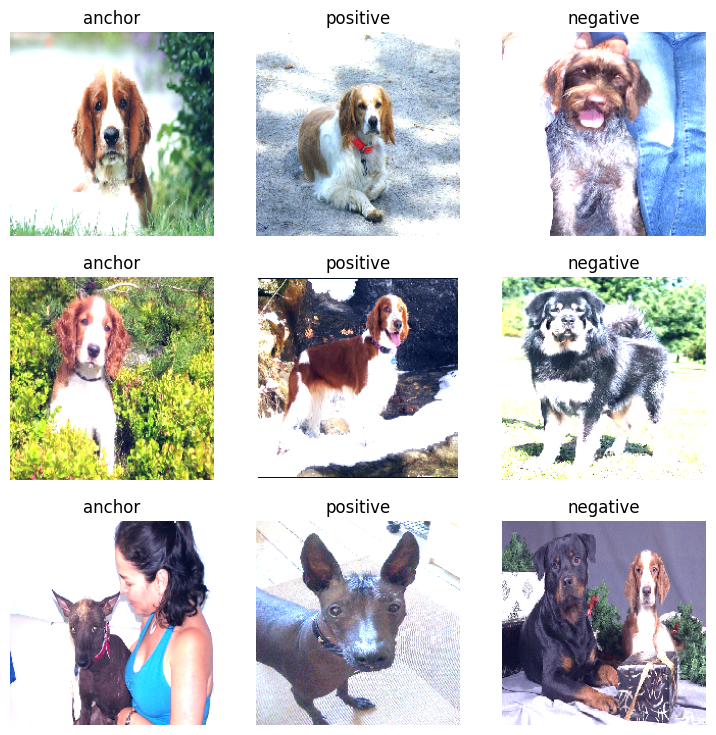

In [16]:
visualize(*query_gen[5])

In [17]:
# 构造获取特征向量的网络

In [18]:
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50


In [19]:
# 加载预训练模型
base_cnn = ResNet50(weights="imagenet", input_shape=(200,200,3), include_top=False)

custom_layers = Sequential([
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),

    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),

    layers.Dense(256)

])
output = custom_layers(base_cnn.output)
# 打包embedding模型
embedding = Model(inputs=base_cnn.input, outputs=output, name="Embedding")

94773248/94765736 [==============================] - 33s 0us/step


In [20]:
# 查看网络架构，查看可以训练的参数量，Keras默认都是可以训练的，除了BatchNormalization层
# base_cnn.summary()

In [21]:
# 迁移学习，冻结conv5_block1_out之前的所有网络层
trainable = False
for layer in base_cnn.layers:
    # conv5_block1_out后的才可以fine tune，其他冻结
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [22]:
# 再次检查
# base_cnn.summary()

In [23]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#used-in-the-notebooks_1

class SiameseModel(Model):

    def __init__(self, embedding, margin=0.5):
        super(SiameseModel, self).__init__()
        
        # embedding网络
        self.embedding = embedding
        # 定义margin
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        # 输入的是图片，返回的是A、P和A、N的距离
        anchor_img = inputs[0]
        positive_img = inputs[1]
        negative_img = inputs[2]
        
        # 计算embedding
        anchor_embedding = self.embedding(anchor_img)
        positive_embedding = self.embedding(positive_img)
        negative_embedding = self.embedding(negative_img)
        
        # 计算欧式距离的平方
        ap_distance = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), -1)
        an_distance = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), -1)
        
        return ap_distance,an_distance

    
    def train_step(self, data):
        # 训练步骤
        # 使用梯度带跟踪梯度
        with tf.GradientTape() as tape:
            # 计算loss
            loss = self._compute_triplet_loss(data)
        # 计算梯度
        gradients = tape.gradient(loss, self.trainable_weights)
        # 优化
        self.optimizer.apply_gradients( zip(gradients, self.trainable_weights) )
        # 更新loss
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        # 测试集评估
        loss = self._compute_triplet_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_triplet_loss(self, data):
        # 计算triplet loss
        # 计算距离
        ap_distance, an_distance = self.call(data)
        # 计算loss
        loss = tf.maximum(ap_distance + self.margin - an_distance, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]


In [24]:
# 实例化
siamese_model = SiameseModel(embedding, margin=0.5)

In [25]:
# 测试输出
output = siamese_model(traingen[0])

In [26]:
output

(<tf.Tensor: shape=(32,), dtype=float32, numpy=
 array([275.9058 , 389.32324, 625.71124, 451.28104, 346.6337 , 634.5349 ,
        624.55023, 548.90717, 523.93585, 328.6032 , 345.17963, 403.54242,
        425.6823 , 520.4495 , 476.64175, 369.01868, 413.59204, 510.78894,
        245.76973, 631.64154, 424.45404, 461.16205, 430.84018, 314.76657,
        465.57764, 520.9015 , 440.112  , 305.3354 , 338.5517 , 487.239  ,
        366.253  , 478.99936], dtype=float32)>,
 <tf.Tensor: shape=(32,), dtype=float32, numpy=
 array([357.3423 , 413.92462, 430.7871 , 413.35492, 531.7415 , 426.4353 ,
        401.26816, 683.0129 , 299.5645 , 446.7463 , 542.766  , 490.8352 ,
        489.65625, 490.69058, 427.1518 , 516.45966, 433.59747, 378.9592 ,
        404.44452, 571.5078 , 433.43292, 423.16083, 391.13934, 526.94116,
        473.74655, 502.28766, 442.7065 , 377.0797 , 450.88922, 463.84686,
        528.1314 , 459.43414], dtype=float32)>)

In [27]:
# 编译模型
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [28]:
# 训练50个epoch
history = siamese_model.fit(traingen,validation_data=test_gen,epochs=30)

Epoch 1/30
100/100 [==============================] - 96s 879ms/step - loss: 9.4835 - val_loss: 1.0841
Epoch 2/30
 12/100 [==>...........................] - ETA: 1:09 - loss: 0.9428

KeyboardInterrupt: 

In [ ]:
# 保存模型，注意保存的是提取特征的模型

In [ ]:
embedding.save('latest_new.h5')

In [ ]:
# 绘制图

In [ ]:
import pandas as pd

In [ ]:
history_pd = pd.DataFrame(history.history)

In [ ]:
# 查看损失
plt.plot(history_pd['loss'])
plt.plot(history_pd['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train set','test set'],loc='upper right')
plt.show()